# July 20, 22: Plot trial level response time series
individually for each trial for each subject.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)

from brainiak.isc import (
    isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc, 
    _check_timeseries_input, _check_targets_input, _threshold_nans
)
from brainiak.fcma.util import compute_correlation

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jul22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils

In [2]:
'''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

args.provide_roi_idxs = True
if args.provide_roi_idxs:
    with open(f"{proj_dir}/data/max/exploratory_data_roi_indices.pkl", 'rb') as f:
        args.up_roi_idxs, args.down_roi_idxs, args.roi_idxs = pickle.load(f)
        args.num_rois = len(args.roi_idxs)
else:
    args.num_rois = 85
    args.roi_idxs = np.arange(args.num_rois)

with open(f"{proj_dir}/data/max/exploratory_data_trial_level_responses.pkl", 'rb') as f:
    X = pickle.load(f)

'''
change roi ordering
'''
for label in args.LABELS:
    for idx_subj in range(len(X[label])):
        X[label][idx_subj] = X[label][idx_subj][:, :, args.roi_idxs]

In [3]:
'''
find minimum number of trials across subjects
'''
min_trials = []
for label in args.LABELS:
    min_trials += [x.shape[0] for x in X[label]]
min_trials = min(min_trials)
print(f"minimum number of trials = {min_trials}")

minimum number of trials = 11


In [12]:
'''
time series of early and late periods
'''
args.PERIODS = ['early', 'late']
# time periods
args.TR = 1.25 #seconds
EARLY = np.arange(2.5, 8.75+args.TR, args.TR) // args.TR
LATE = np.arange(10.0, 16.25+args.TR, args.TR) // args.TR
EARLY = EARLY.astype(int)
LATE = LATE.astype(int)
args.PERIOD_TRS = [EARLY, LATE]

ts = {}
for label, name in zip(args.LABELS, args.NAMES):
    for idx_period, (period, TRs) in enumerate(zip(args.PERIODS, args.PERIOD_TRS)):
        ts[f"{name}_{period}"] = []
        for x in X[label]:
            x = x[:, args.PERIOD_TRS[idx_period], :]
            trl, t, r = x.shape
            x = np.reshape(x[:min_trials, ...], (min_trials*t, r))
            ts[f"{name}_{period}"] += [zscore(x, axis=0, nan_policy='omit')]
            # ts[f"{name}_{period}"] += [x]
            # ts[f"{name}_{period}"].append(x)

nan_masks = {}; nan_any_masks = {}; nan_all_any_masks = {}
for block in ts.keys():
    ts[block] = np.dstack(ts[block])
    nan_masks[block] = np.isnan(ts[block])
    nan_any_masks[block] = np.any(np.isnan(ts[block]), axis=0, keepdims=True)
    nan_all_any_masks[block] = np.all(np.all(np.isnan(ts[block]), axis=0, keepdims=True), axis=2)

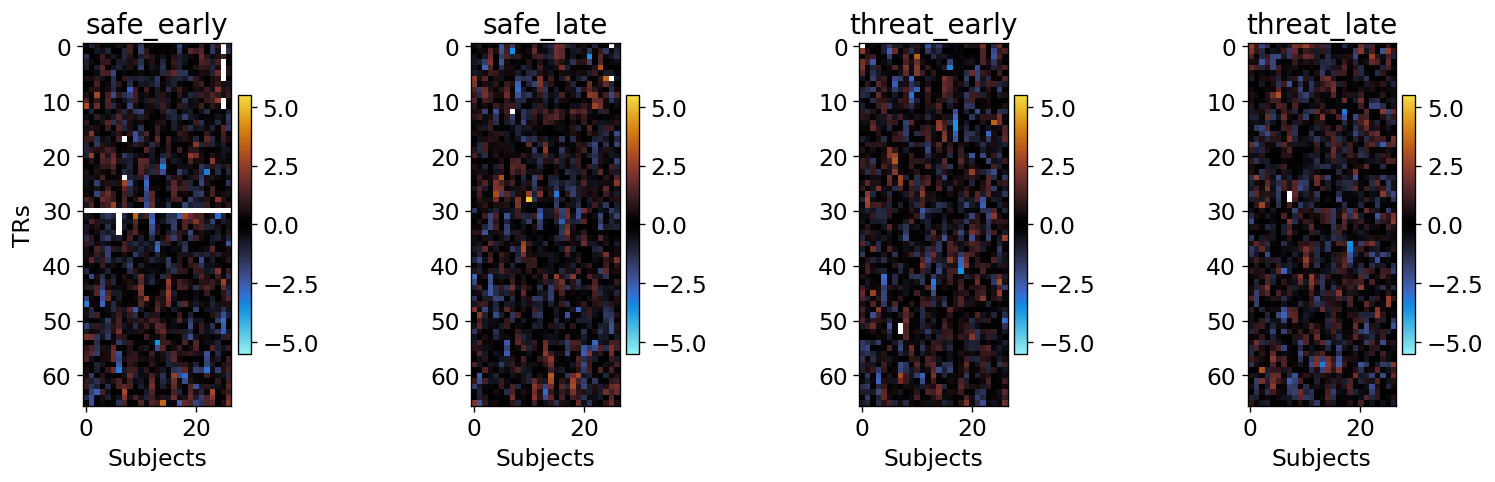

In [5]:
roi = 0 # fix an roi as a NaN value at a TR will percolate to all rois.

nrows, ncols = 1, 4
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(4*ncols, 4*nrows), 
    sharex=False, 
    sharey=False, 
    dpi=120,
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

for idx_block, block in enumerate(ts.keys()):
    ax = axs[idx_block]

    im = ax.imshow(
        ts[block][:, roi, :],
        cmap=cmr.iceburn,
        vmin=-5.5, vmax=5.5
    )
    ax.figure.colorbar(im, ax=ax, fraction=0.040, pad=0.02)

    ax.set_xlabel(f"Subjects")
    if idx_block == 0: ax.set_ylabel(f"TRs")
    ax.set_title(f"{block}")

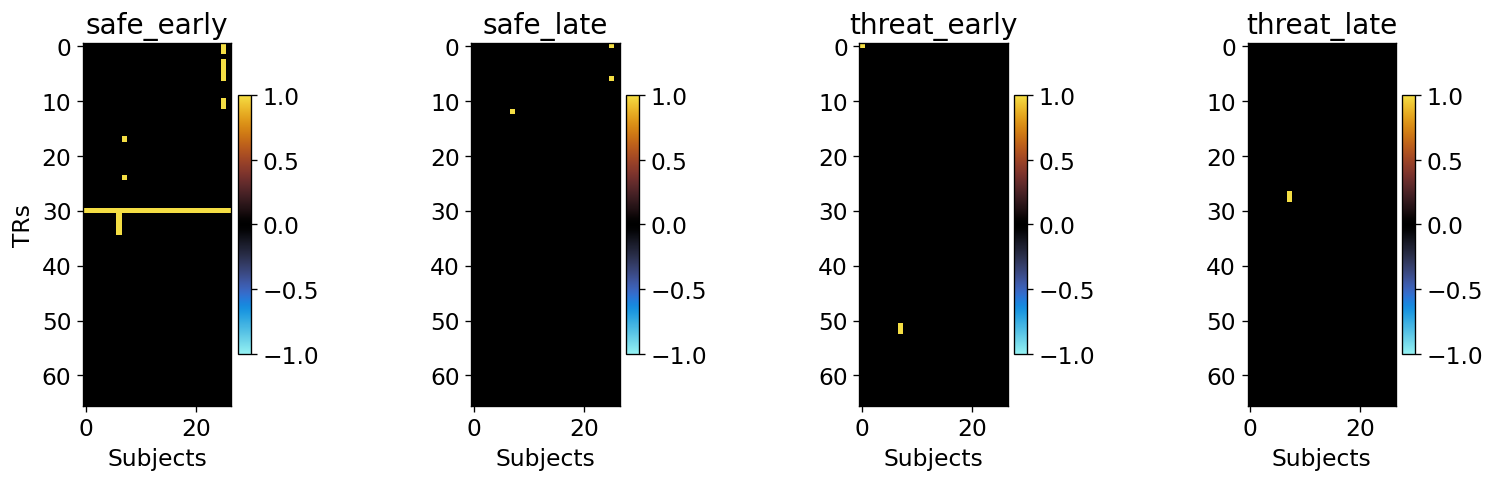

In [6]:
roi = 0 # fix an roi as a NaN value at a TR will percolate to all rois.

nrows, ncols = 1, 4
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(4*ncols, 4*nrows), 
    sharex=False, 
    sharey=False, 
    dpi=120,
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

for idx_block, block in enumerate(nan_masks.keys()):
    ax = axs[idx_block]

    im = ax.imshow(
        nan_masks[block][:, roi, :],
        cmap=cmr.iceburn,
        vmin=-1.0, vmax=1.0
    )
    ax.figure.colorbar(im, ax=ax, fraction=0.040, pad=0.02)

    ax.set_xlabel(f"Subjects")
    if idx_block == 0: ax.set_ylabel(f"TRs")
    ax.set_title(f"{block}")

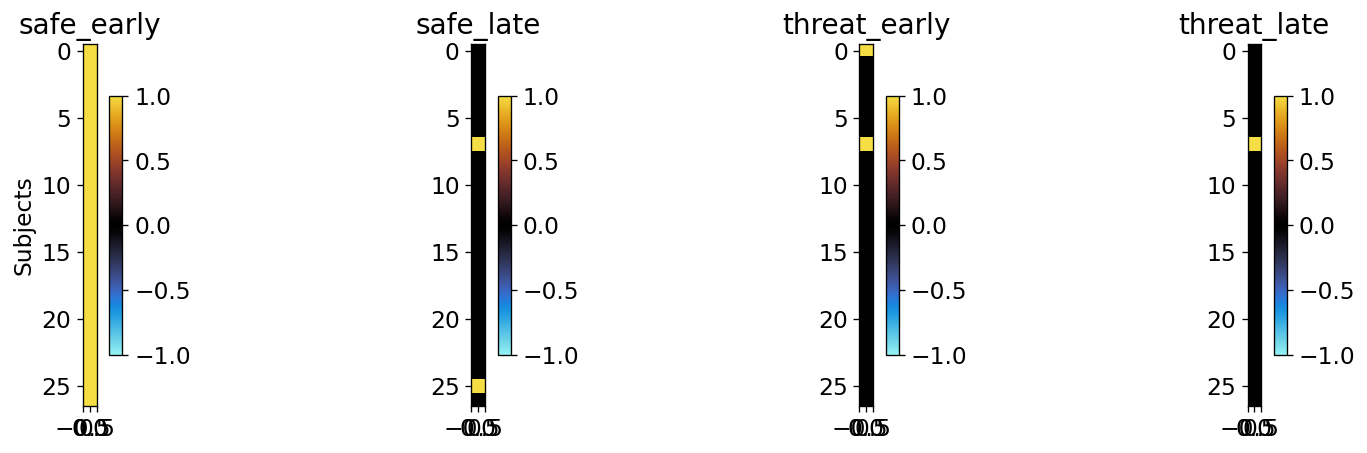

In [7]:
roi = 0 # fix an roi as a NaN value at a TR will percolate to all rois.

nrows, ncols = 1, 4
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(4*ncols, 4*nrows), 
    sharex=False, 
    sharey=False, 
    dpi=120,
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

for idx_block, block in enumerate(nan_any_masks.keys()):
    ax = axs[idx_block]

    im = ax.imshow(
        nan_any_masks[block][:, roi, :].T,
        cmap=cmr.iceburn,
        vmin=-1.0, vmax=1.0
    )
    ax.figure.colorbar(im, ax=ax, fraction=0.040, pad=0.04)

    ax.set_xlabel(f"")
    if idx_block == 0: ax.set_ylabel(f"Subjects")
    ax.set_title(f"{block}")
    

In [13]:
nan_all_any_masks

{'safe_early': array([[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]]),
 'safe_late': array([[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]]),
 'threat_early': array([[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,

Seeing ISFC for subject 7 because this subject has nan in one TR, resulting in masking of the whole time series of the subject.

In [17]:
'''
compute ISFC
'''
mean = np.nanmean
block = 'safe_early'
data = ts[block]
targets = data
symmetric = True

data = np.rollaxis(data, 2, 0)
targets = np.rollaxis(targets, 2, 0)

isfcs = [compute_correlation(np.ascontiguousarray(subject.T),
                            np.ascontiguousarray(mean(
                                np.delete(targets, s, axis=0),
                                axis=0).T),
                            return_nans=True)
        for s, subject in enumerate(data)]

isfcs = np.dstack([(isfc_matrix + isfc_matrix.T) / 2 if
                    symmetric else isfc_matrix for
                    isfc_matrix in isfcs])

display(isfcs[:, :, 7])
display(np.where(np.isnan(data[7])))
display(zscore(data[7], axis=0, ddof=0))
display(np.sum(np.isnan(np.corrcoef(data[7], data[8])[:43, 43:])))

/tmp/ipykernel_9803/1436769480.py:14: RuntimeWarning: Mean of empty slice
  np.ascontiguousarray(mean(


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

(array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42,  0,  1,  2,  3,  4,  5,  6,  7,
         8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
        42,  0,  1,  2,  3,  4,  5,  6

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

307

In [15]:
isfcs = isfc(
    ts[block],
    pairwise=False,
    summary_statistic=None, 
    vectorize_isfcs=False
)

display(isfcs)

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/brainiak/isc.py:341: RuntimeWarning: Mean of empty slice
  np.ascontiguousarray(mean(


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [11]:
a = np.array([np.nan, np.nan])
b = np.array([np.nan, np.nan])
np.nanmean([a, b], axis=1)

/tmp/ipykernel_9803/1732644666.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean([a, b], axis=1)


array([nan, nan])

In [22]:
'''
using `np.corrcoef` instead of cython's function
'''
from scipy.stats import pearsonr
a = np.random.randn(3, 5)
b = np.random.randn(3, 5)
pearsonr(a, b)

TypeError: No loop matching the specified signature and casting was found for ufunc add